In [1]:
!pip install tensorflow==2.15.0
!pip install keras==2.15.0
!pip install keras-cv==0.6.1 keras-core
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import optimizers
import keras_cv
import numpy as np
from keras_cv import bounding_box
import os
import resource
from keras_cv import visualization
import tqdm
import json
!gdown 1wqEbF4V3PwLzyaR7nM0LyTt01RL44hcc
!unzip archivetest.zip -d .
with open('Senior-Design-VIAD-4/train/_annotations.coco.json') as f:
  j = json.load(f)

class_mapping = {c['id']: c['name'] for c in j['categories']}
image_paths = [f"Senior-Design-VIAD-4/train/{d['file_name']}" for d in j['images']]
classes = [[] for _ in image_paths]
bounding_boxes = [[] for _ in image_paths]
for a in j['annotations']:
  if a['category_id'] not in [2,5,6,8,9,11,12,13,14,15,18,19,23,26,27,29,32,35]:
    idx = a['image_id']
    classes[idx].append(a['category_id'])
    bounding_boxes[idx].append(a['bbox'])
no_annotations = [len(x) == 0 for x in classes]
image_paths = [x for x, na in zip(image_paths, no_annotations) if not na]
classes = [x for x, na in zip(classes, no_annotations) if not na]
bounding_boxes = [x for x, na in zip(bounding_boxes, no_annotations) if not na]
bbox = tf.ragged.constant(bounding_boxes)
classes = tf.ragged.constant(classes)
image_paths = tf.ragged.constant(image_paths)

data = tf.data.Dataset.from_tensor_slices((image_paths, classes, bbox))
smalldata = data.take(10_000)
val_data = smalldata.take(2_000)
train_data = smalldata.skip(2_000)
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    return image


def load_dataset(image_path, classes, bbox):
    # Read Image
    image = load_image(image_path)
    bounding_boxes = {
        "classes": tf.cast(classes, dtype=tf.float32),
        "boxes": bbox,
    }
    return {
        "images": tf.cast(image, tf.float32), "bounding_boxes": bounding_boxes}
BATCH_SIZE = 5
augmenter = keras.Sequential(
    layers=[
        keras_cv.layers.RandomFlip(
            mode="horizontal", bounding_box_format="xywh"),
        keras_cv.layers.RandomShear(
            x_factor=0.2, y_factor=0.2, bounding_box_format="xywh"
        ),
        keras_cv.layers.JitteredResize(
            target_size=(640, 640),
            scale_factor=(0.75, 1.3),
            bounding_box_format="xywh"
        ),
    ]
)
# Create train dataset
train_ds = train_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(BATCH_SIZE * 4)
train_ds = train_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
train_ds = train_ds.map(augmenter, num_parallel_calls=tf.data.AUTOTUNE)
# Create validation dataset
resizing = keras_cv.layers.Resizing(
    640, 640, bounding_box_format="xywh", pad_to_aspect_ratio=True
)

val_ds = val_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.shuffle(BATCH_SIZE * 4)
val_ds = val_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
val_ds = val_ds.map(resizing, num_parallel_calls=tf.data.AUTOTUNE)

def dict_to_tuple(inputs):
    return inputs["images"], bounding_box.to_dense(
        inputs["bounding_boxes"], max_boxes=32
    )


train_ds = train_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

val_ds = val_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

# Global clipnorm helps to reduce exploding gradient

base_lr = 0.005
# including a global_clipnorm is extremely important in object detection tasks
optimizer = tf.keras.optimizers.SGD(
    learning_rate=base_lr, momentum=0.9, global_clipnorm=10.0
)

# Creates a "RetinaNet" from ResNet50 backbone

model = keras_cv.models.RetinaNet.from_preset(
    "resnet50_imagenet",
    num_classes=len(class_mapping),
    bounding_box_format="xywh",
)

# model.compile(
#     classification_loss="focal",
#     box_loss="smoothl1",
#     optimizer=optimizer,
# )

Streaming output truncated to the last 5000 lines.
  inflating: ./Senior-Design-VIAD-4/train/traffic-light-819-_jpg.rf.c1c1e751997edc4f93c8228819ee4d9b.jpg  
  inflating: ./Senior-Design-VIAD-4/train/traffic-light-819-_jpg.rf.c9f5c9073b96bc00533b5eed84732662.jpg  
  inflating: ./Senior-Design-VIAD-4/train/traffic-light-819-_jpg.rf.cbcb390c28ccff14d3319e134de7add2.jpg  
  inflating: ./Senior-Design-VIAD-4/train/traffic-light-819-_jpg.rf.e5d470d3d89806960f99f226adfb33aa.jpg  
  inflating: ./Senior-Design-VIAD-4/train/traffic-light-819-_jpg.rf.f037177920fc67483d02505d6d3b0ca7.jpg  
  inflating: ./Senior-Design-VIAD-4/train/traffic-light-819-_jpg.rf.fe97e03dc6ce989849a6cf6f34971d70.jpg  
  inflating: ./Senior-Design-VIAD-4/train/traffic-light-82-_jpg.rf.1ae61c54c196baf8c894792b2788776d.jpg  
  inflating: ./Senior-Design-VIAD-4/train/traffic-light-82-_jpg.rf.4884e1aab45b39e90af93f0a3430c6fb.jpg  
  inflating: ./Senior-Design-VIAD-4/train/traffic-light-82-_jpg.rf.4c60603d3563339bc163fed6671c

In [3]:
!unzip mymodel.zip -d .
# Create a new model instance
# modelx = Model()

latest = tf.train.latest_checkpoint("mymodel.ckpt")
# Load the previously saved weights
model.load_weights(latest)

# Re-evaluate the model
loss, acc = model.evaluate(val_ds, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

Archive:  mymodel.zip
replace ./mymodel.ckpt/fingerprint.pb? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
 extracting: ./mymodel.ckpt/fingerprint.pb  
  inflating: ./mymodel.ckpt/saved_model.pb  
  inflating: ./mymodel.ckpt/keras_metadata.pb  
  inflating: ./mymodel.ckpt/variables/variables.index  
  inflating: ./mymodel.ckpt/variables/variables.data-00000-of-00001  


AttributeError: 'NoneType' object has no attribute 'endswith'

In [4]:
!unzip fullmodel.zip -d .

Archive:  fullmodel.zip
   creating: ./fullmodel/
 extracting: ./fullmodel/fingerprint.pb  
   creating: ./fullmodel/assets/
  inflating: ./fullmodel/saved_model.pb  
  inflating: ./fullmodel/keras_metadata.pb  
   creating: ./fullmodel/variables/
  inflating: ./fullmodel/variables/variables.index  
  inflating: ./fullmodel/variables/variables.data-00000-of-00001  


In [6]:
new_model = tf.keras.models.load_model('fullmodel', compile=False)

In [7]:
new_model.summary()

Model: "retina_net_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 images (InputLayer)         [(None, None, None, 3)]      0         []                            
                                                                                                  
 model_2 (Functional)        {'P3': (None, None, None,    2356115   ['images[0][0]']              
                             512),                        2                                       
                              'P4': (None, None, None,                                            
                             1024),                                                               
                              'P5': (None, None, None,                                            
                             2048)}                                                    

In [12]:
new_model.compile(
    classification_loss="focal",
    box_loss="smoothl1",
    optimizer=optimizer,
)

In [13]:
new_model.prediction_decoder = keras_cv.layers.MultiClassNonMaxSuppression(
    bounding_box_format="xywh",
    from_logits=True,
    iou_threshold=0.7,
    confidence_threshold=0.4,
)

In [14]:
def processit(img, y_pred):
    print(y_pred)
    image_height, image_width, _ = img.shape
            # image = Image.open(f"{INPUT_DIRECTORY}/radio.png")
            # new_image = image.resize((64, 64))
            # new_image.save('xyz.png')
            # img = cv2.imread("xyz.png")
            # img2 = cv2.resize(img, (64, 64))
            # print(img2.shape)

    #image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # m = tf.keras.models.load_model("tfmodel")

    #out = face_detection.process(image_rgb)
    # out = m.predict(img2)

    # if y_pred.detections is not None:
    for ind in range(len(y_pred["boxes"][0])):
        box = y_pred["boxes"][0][ind].numpy()
        x1, y1, w, h = box[0], box[1], box[2], box[3]

        # print(str(x1) + "," + str(y1) + "," +  str(w) + "," + str(h))

        x1 = int(x1)
        y1 = int(y1)
        w = int(w)
        h = int(h)
        area = w*h
        print(area)

        color = (0, 255, 0)
        if area > 18000:
          color = (0, 0, 255)
        #image[y1: y1 + h, x1:x1 + w, :] = cv2.blur(image[y1:(y1 + h), x1:(x1 + w), :], (30, 30))
        img = cv2.rectangle(img, (x1, y1), (x1 + w, y1 + h), color, 2)
        cv2.putText(img, class_mapping[int(y_pred["classes"][0][ind])], (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)
    return img

1/1 [==============================] - 5s 5s/step
{'boxes': <tf.RaggedTensor [[[476.88992, 246.98747, 54.37509, 109.6479]]]>, 'confidence': <tf.RaggedTensor [[0.9151836]]>, 'classes': <tf.RaggedTensor [[28.0]]>, 'num_detections': array([1], dtype=int32)}
5886


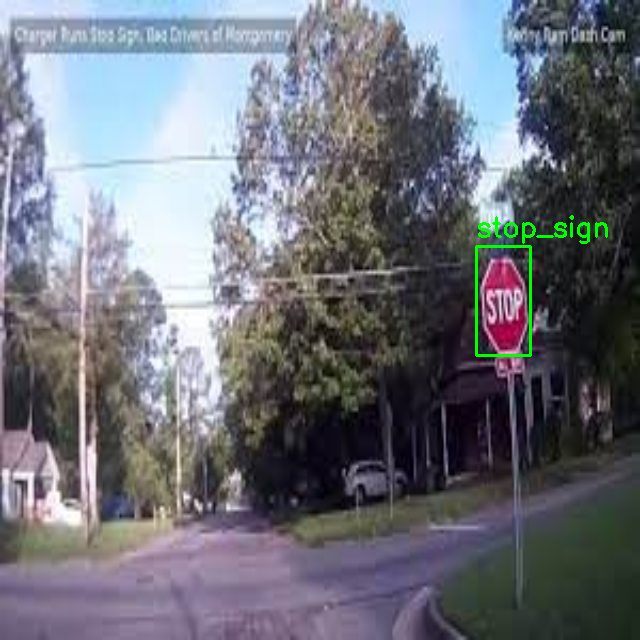

In [15]:
from google.colab.patches import cv2_imshow
import cv2
img2 = cv2.imread("stop3.jfif")
img2 = cv2.resize(img2, (640, 640))
img = cv2.imread("stop3.jfif")
img = cv2.resize(img, (640, 640))
img = np.expand_dims(img, axis=0)
y_pred = new_model.predict(img)
x = processit(img2, y_pred)
cv2_imshow(x)
# video_capture = cv2.VideoCapture("test6.mov")
# ret, frame = video_capture.read()
# a = frame.shape[1]
# b = frame.shape[0]

# output_video = cv2.VideoWriter("test6p.mp4",
#                                 cv2.VideoWriter_fourcc(*"MP4V"),
#                                 25,
#                                 (a, b))

# while ret:
#     frame = cv2.resize(frame, (640, 640))
#     frame2 = cv2.resize(frame, (640, 640))
#     frame2 = np.expand_dims(frame2, axis=0)
#     x = model.predict(frame2)
#     frame = processit(frame, x)
#     frame = cv2.resize(frame, (a, b))
#     output_video.write(frame)

#     ret, frame = video_capture.read()

# video_capture.release()
# output_video.release()

In [16]:
loss, acc = new_model.evaluate(val_ds, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

KeyboardInterrupt: 